In [2]:
# Import packages
%load_ext autoreload
%autoreload 2
import os

import numpy as np
import matplotlib.pyplot as plt
import scarlet
import pickle

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP

import sep

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, hstack
from astropy.coordinates import SkyCoord

#plt.rcParams['font.size'] = 15
#plt.rc('image', cmap='inferno', interpolation='none', origin='lower')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Make one figure containing all useful information

In [4]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.utils.set_matplotlib(style='default', usetex=False)

In [17]:
lsbg_cat = Table.read('./Cutout/NSA/nsa_cutout_cat.fits')
lsbg_cat.sort('viz-id')

In [18]:
lsbg_cat[0]

ra,dec,a_image,b_image,theta_image,ellipticity,mag_auto_g,mag_auto_r,mag_auto_i,flux_radius_ave_g,flux_radius_ave_i,mu_ave_g,mu_ave_i,acorr_ratio,g-i,g-r,A_g,A_r,A_i,tract,patch,synth_id,viz-id,is_candy,is_galaxy,is_tidal,is_outskirts,is_cirrus,is_junk,num_votes,good_votes,bad_votes,cutout_size,prefix,radius,image_flag [5],psf_flag [5]
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcmin,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,bytes3,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,bytes57,float64,bool,bool
191.8775898,1.8191396,13.171,6.847,17.16,0.48,20.3681,19.6069,19.419,2.48388,2.9379,23.63544893666136,23.162196553690602,1.3531789075180445,0.8617938102989308,0.676572821840797,0.057065463894592376,0.04043828573538853,0.02885927419352259,9841,"4,2",-1,1554,2,0,0,0,0,0,2,2,0,1.0,/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_1554,1.0,True .. True,True .. True


### Run scarlet modeling

In [12]:
from kuaizi.fitting import fitting_wavelet_obs_tigress, _fitting_wavelet

In [13]:
# scarlet_flag
# 0: not processed
# 1: no bug
# -1: problematic
# lsbg_cat['scarlet_flag_0.5'] = np.zeros(len(lsbg_cat), dtype=int)

In [14]:
fail_logger = kz.utils.set_logger(logger_name='nsa_test_fail', file_name='nsa_fail', level='ERROR')
global_logger = kz.utils.set_logger(logger_name='nsa_test', file_name='nsa_log', level='INFO')

### Running scarlet wavelet modeling for `/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_1554`
    Working directory: /scratch/gpfs/jiaxuanl/Data/HSC/LSBG
  - Detect sources and make mask
    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    6 stars from Gaia are masked!
    Detected 61 objects
    6 stars from Gaia are masked!
    Detected 78 objects
    Detected 25 objects
  - Wavelet modeling with the following hyperparameters:
    min_grad = -0.20, starlet_thresh = 0.50 (contam_ratio = 0.04).
    Total number of sources: 6
    Optimizaiton: Succeed for e_rel = 1e-04 with 40 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 1e-05 with 125 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 5e-05 with 127 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 1e-06 with 277 iterations! Try higher accuracy!
  - After 277 iterations, logL = 1603165.29
    Elapsed time for fitting: 143.06 s
  - Components [0

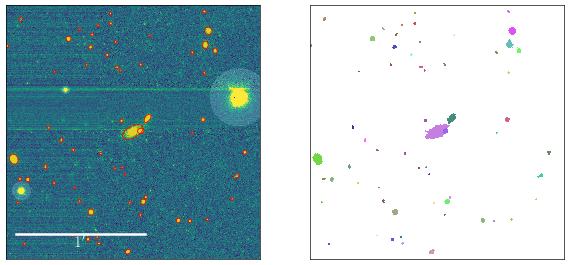

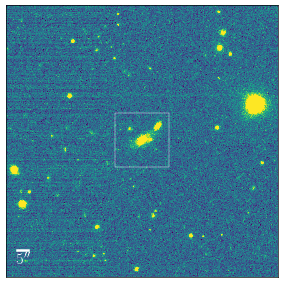

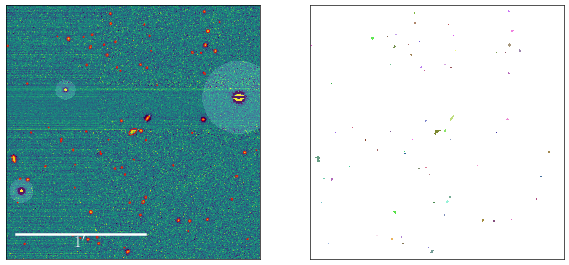

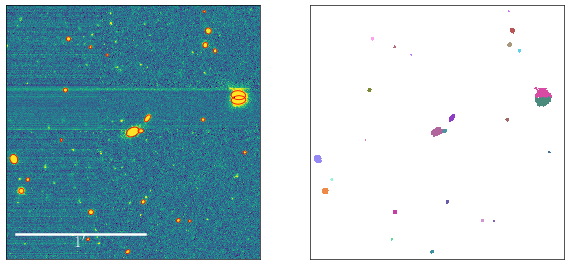

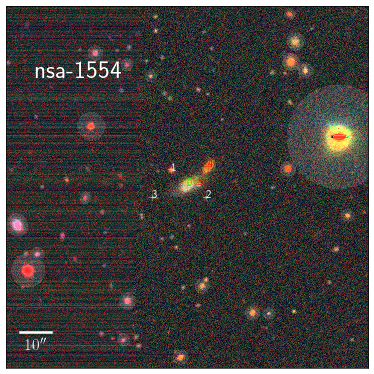

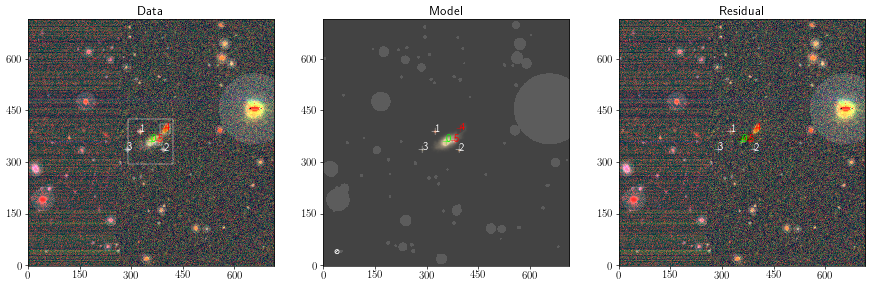

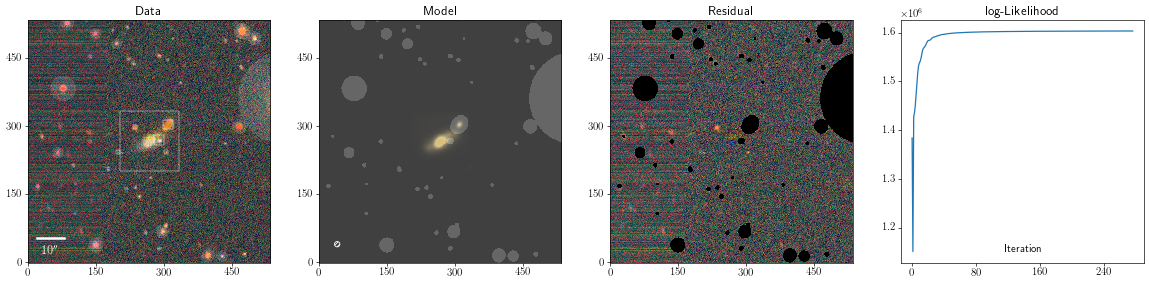

In [19]:
index = 0
blend = fitting_wavelet_obs_tigress(
    {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}, 
    lsbg_cat[index],
    name='viz-id',
    channels='griz',
    starlet_thresh=0.5,
    prefix='nsa',
    show_figure=True, 
    global_logger=None, # global_logger, 
    fail_logger=None, # fail_logger
)

# if blend: # if succeeded
#     lsbg_cat[index]['scarlet_flag_0.5'] = 1
# else:
#     lsbg_cat[index]['scarlet_flag_0.5'] = -1

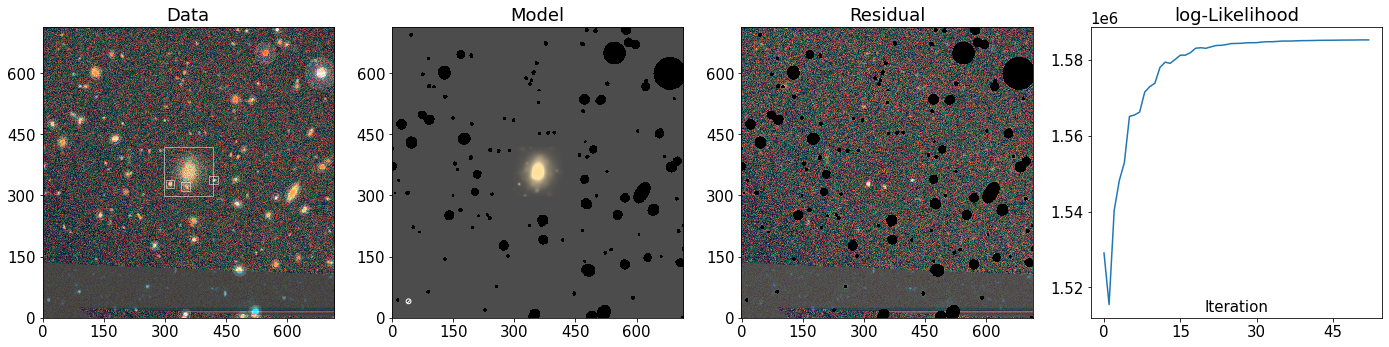

In [97]:
fig = kz.display.display_scarlet_results_tigress(
        blend,
        show_ind=[0],
        #zoomin_size=120,
        minimum=-0.3,
        stretch=1,
        Q=1,
        channels='griz',
        show_loss=True,
        show_mask=True,
        show_mark=False,
        scale_bar=False)

#plt.savefig('/tigress/jiaxuanl/public_html/candy/candy-2-zoomin.png', dpi=55, bbox_inches='tight')

## Multiprocessing

In [24]:
suffix = '_test'
fail_logger = kz.utils.set_logger(
    logger_name='candy_fail' + suffix, file_name='candy_fail' + suffix, level='ERROR')
global_logger = kz.utils.set_logger(
    logger_name='candy_sample' + suffix, file_name='candy_log' + suffix, level='INFO')
#lsbg_cat['scarlet_flag_0.5'] = np.zeros(len(lsbg_cat), dtype=int)

In [25]:
from multiprocessing import Pool, Manager
from functools import partial

In [ ]:
def multiprocess_fitting(index):
    #if not os.path.isfile(f'./Models/LSBG-{lsbg_cat[index]["Seq"]:04d}-trained-model-wavelet.df'): 
    blend = fitting_wavelet_obs_tigress(
        {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/tiger/scratch/gpfs/jiaxuanl/Data'}, 
        lsbg_cat[index],
        name='Seq',
        channels='griz',
        starlet_thresh=0.5,
        prefix='candy',
        show_figure=False, 
        global_logger=global_logger,
        fail_logger=fail_logger)
    
print('Number of processor to use:')
n_jobs = 6
manager = Manager()
pool = Pool(n_jobs)

#measurement_cat = manager.dict()
iterable = np.arange(50, 100, 1) # np.random.randint(0, len(lsbg_cat), 50)

#func = partial(fitting_single_comp, s18a)
pool.map(multiprocess_fitting, iterable)
pool.close()
pool.join()